## Machine learning modeling - Iteration #3

In [111]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from scipy.stats.mstats import winsorize
from scipy.stats import zscore, stats
from math import ceil
import jenkspy
import statsmodels
import statsmodels.api as sm

# ml modules
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn import ensemble
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [144]:
# read in 990 data that has been
# with features already adjusted in first iteration
df = pd.read_csv('data/990_model_data_3.csv')

In [145]:
df.shape

(26881, 28)

In [146]:
df.head()

,org_form_corp,org_form_trust,org_form_association,org_form_other_form,exempt_status_501c_txt,gross_receipts,voting_memb_ct,voting_indepmemb_ct,employee_tot_ct,volunteer_tot_ct,income_tot_unrelated,income_net_unrelated,rev_less_expense_prioryr,asset_tot_beginyr,liability_tot_beginyr,asset_net_beginyr,rev_less_expense_curyr,asset_tot_endyr,liability_tot_endyr,asset_net_endyr,contractor_100k_ct,CON_CT_DIV_EMP_VOL_CT,CON_EXP_DIV_TOT_EXP,CON_CT_DIV_EMP_VOL_CT_flag,CON_EXP_DIV_TOT_EXP_flag,TARGET_FEATURE,rev_PCA,exp_PCA
0,True,False,False,False,12_,15549792.0,11,11,37,0.0,0.0,0.0,0.0,39372255.0,26541056.0,12831199.0,0.0,39367859.0,26785093.0,12582766.0,3,0.081081,0.061503,True,False,False,-9.230988e+07,-7.560677e+07
1,True,False,False,False,14_,9472036.0,9,8,81,8.0,52565.0,-75519.0,1000243.0,173898488.0,157544120.0,16354368.0,1262299.0,188534687.0,170915216.0,17619471.0,3,0.033708,0.137033,False,False,False,-1.057983e+08,-9.231641e+07
2,True,False,False,False,5_,8503978.0,21,19,53,200.0,16110.0,0.0,-55531.0,3510564.0,820701.0,2689863.0,69972.0,3640881.0,852359.0,2788522.0,3,0.011858,0.053652,False,False,False,-1.072903e+08,-9.229491e+07
3,True,False,False,False,3_,57422298.0,8,7,442,15.0,0.0,0.0,2553132.0,57577945.0,13230564.0,44347381.0,90630.0,56726534.0,12198910.0,44527624.0,8,0.017505,0.039592,False,False,False,-1.765087e+07,-1.757254e+07
4,True,False,False,False,7_,5974176.0,12,12,139,50.0,2437.0,1437.0,344252.0,9803605.0,3104088.0,6699517.0,745724.0,10535130.0,3089889.0,7445241.0,1,0.005291,0.039945,False,False,False,-1.162458e+08,-9.964548e+07


## 3rd Feature Iteration

### 1. Drop features that aren't contributing information to my models

In [147]:
# these were deemed not important from prior modeling
df.drop(df[['org_form_corp', 'org_form_trust', 'org_form_association',
       'org_form_other_form']], axis=1, inplace=True)

### 2. Drop dummy features that aren't contributing information to my models

In [148]:
df_dummies = pd.get_dummies(df)

In [149]:
df_dummies.drop(df_dummies[['exempt_status_501c_txt_10_',
       'exempt_status_501c_txt_12_', 'exempt_status_501c_txt_13_',
       'exempt_status_501c_txt_14_', 'exempt_status_501c_txt_18_',
       'exempt_status_501c_txt_19_', 'exempt_status_501c_txt_23_',
       'exempt_status_501c_txt_25_', 'exempt_status_501c_txt_26_',
       'exempt_status_501c_txt_27_', 'exempt_status_501c_txt_29_',
       'exempt_status_501c_txt_2_', 'exempt_status_501c_txt_5_',
       'exempt_status_501c_txt_7_', 'exempt_status_501c_txt_8_',
       'exempt_status_501c_txt_9_']], axis=1, inplace=True)

### 3. Combine asset features

In [150]:
# identify columns
for c in df.columns:
    if 'asset' in c:
        print(c)      

asset_tot_beginyr
asset_net_beginyr
asset_tot_endyr
asset_net_endyr


In [151]:
# combine asset features using pca
pca = PCA(n_components=1)
df_dummies['asset_PCA'] = pca.fit_transform(
         df[['asset_tot_beginyr',
        'asset_net_beginyr',
        'asset_tot_endyr',
        'asset_net_endyr']])                                
                                     

print(pca.explained_variance_ratio_)

[0.94053634]


In [152]:
# drop features that have been consolidated
df_dummies.drop(df_dummies[['asset_tot_beginyr',
        'asset_net_beginyr',
        'asset_tot_endyr',
        'asset_net_endyr']], axis=1, inplace=True)

In [153]:
df_dummies.head()

,gross_receipts,voting_memb_ct,voting_indepmemb_ct,employee_tot_ct,volunteer_tot_ct,income_tot_unrelated,income_net_unrelated,rev_less_expense_prioryr,liability_tot_beginyr,rev_less_expense_curyr,liability_tot_endyr,contractor_100k_ct,CON_CT_DIV_EMP_VOL_CT,CON_EXP_DIV_TOT_EXP,CON_CT_DIV_EMP_VOL_CT_flag,CON_EXP_DIV_TOT_EXP_flag,TARGET_FEATURE,rev_PCA,exp_PCA,exempt_status_501c_txt_3_,exempt_status_501c_txt_4_,exempt_status_501c_txt_6_,asset_PCA
0,15549792.0,11,11,37,0.0,0.0,0.0,0.0,26541056.0,0.0,26785093.0,3,0.081081,0.061503,True,False,False,-9.230988e+07,-7.560677e+07,0,0,0,-9.988990e+07
1,9472036.0,9,8,81,8.0,52565.0,-75519.0,1000243.0,157544120.0,1262299.0,170915216.0,3,0.033708,0.137033,False,False,False,-1.057983e+08,-9.231641e+07,0,0,0,8.416525e+07
2,8503978.0,21,19,53,200.0,16110.0,0.0,-55531.0,820701.0,69972.0,852359.0,3,0.011858,0.053652,False,False,False,-1.072903e+08,-9.229491e+07,0,0,0,-1.516665e+08
3,57422298.0,8,7,442,15.0,0.0,0.0,2553132.0,13230564.0,90630.0,12198910.0,8,0.017505,0.039592,False,False,False,-1.765087e+07,-1.757254e+07,1,0,0,-5.797805e+07
4,5974176.0,12,12,139,50.0,2437.0,1437.0,344252.0,3104088.0,745724.0,3089889.0,1,0.005291,0.039945,False,False,False,-1.162458e+08,-9.964548e+07,0,0,0,-1.406094e+08


In [154]:
# create features for classification
# while removing those I created in designing
# my target variable
X = df_dummies.drop(['TARGET_FEATURE',
            'CON_CT_DIV_EMP_VOL_CT_flag', 
             'CON_EXP_DIV_TOT_EXP_flag',
            'CON_CT_DIV_EMP_VOL_CT',
            'CON_EXP_DIV_TOT_EXP',
            'volunteer_tot_ct',
            'employee_tot_ct',
            'contractor_100k_ct'], axis=1)

# create target for classification
y = df.TARGET_FEATURE

In [155]:
# split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Random Forrest Classifier 


In [156]:
# create model, check for overfitting
rfc = ensemble.RandomForestClassifier(n_estimators=100, max_depth=8)

cross_val_score(rfc, X, y, cv=5)

array([0.89622466, 0.89213316, 0.8937872 , 0.89601935, 0.89804651])

In [157]:
rfc.fit(X_train, y_train)

predict_train = rfc.predict(X_train)
predict_test = rfc.predict(X_test)

# Accuracy tables
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.001999627976190476
Percent Type II errors: 0.09165736607142858

Test set accuracy:
Percent Type I errors: 0.005207364701506416
Percent Type II errors: 0.09205876883020271


In [158]:
# training results
pd.DataFrame(data=confusion_matrix(y_train, predict_train)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,19101,43
Actual: Yes,1971,389


In [159]:
# testing results
pd.DataFrame(data=confusion_matrix(y_test, predict_test)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,4800,28
Actual: Yes,495,54


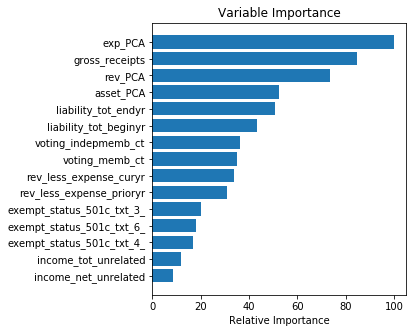

In [160]:
# visualize feature importances
plt.figure(figsize=(10, 5))

feature_importance = 100.0 * (rfc.feature_importances_ / rfc.feature_importances_.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance');


### KNN Classifier

In [161]:
# fit model based on optimized parameters
knn_clf = KNeighborsClassifier(leaf_size= 1, n_neighbors= 110)

knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=110, p=2,
                     weights='uniform')

In [162]:
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=110, p=2,
                     weights='uniform')

In [163]:
predict_train = knn_clf.predict(X_train)
predict_test = knn_clf.predict(X_test)

# Accuracy tables
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.0022786458333333335
Percent Type II errors: 0.10546875

Test set accuracy:
Percent Type I errors: 0.0022317277292170355
Percent Type II errors: 0.09819602008554956


In [164]:
pd.DataFrame(data=confusion_matrix(y_train, predict_train)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,19095,49
Actual: Yes,2268,92


In [165]:
pd.DataFrame(data=confusion_matrix(y_test, predict_test)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,4816,12
Actual: Yes,528,21


### Gradient Boost Classifier

In [166]:
# Initialize and fit the model.
params = {'n_estimators': 950,
          'max_depth': 2,
          'subsample': .8,
          'learning_rate': .1,
          'loss': 'deviance'}

clf = ensemble.GradientBoostingClassifier(**params)

clf.fit(X_train, y_train)
cross_val_score(clf, X, y, cv=5)

array([0.893435  , 0.89027339, 0.88950893, 0.89322917, 0.89562791])

In [167]:
# using the best results from above
# run the model
params = {'n_estimators': 500,
          'max_depth': 2,
          'subsample': .2,
          'learning_rate': .05,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.007765997023809524
Percent Type II errors: 0.09342447916666667

Test set accuracy:
Percent Type I errors: 0.010414729403012832
Percent Type II errors: 0.08666542681792822


In [168]:
pd.DataFrame(data=confusion_matrix(y_train, predict_train)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,18977,167
Actual: Yes,2009,351


In [169]:
pd.DataFrame(data=confusion_matrix(y_test, predict_test)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,4772,56
Actual: Yes,466,83


Compared with first iteration, type I errors decreased, but type II errors increased

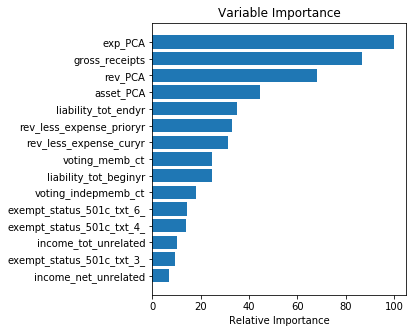

In [170]:
# visualize feature importances
plt.figure(figsize=(10, 5))

feature_importance = 100.0 * (clf.feature_importances_ / clf.feature_importances_.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance');

### SVC

In [171]:
svc = SVC(gamma='scale', C= 1, class_weight=  'balanced', verbose=True)

svc.fit(X_train, y_train)

[LibSVM]

SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=True)

In [172]:
predict_train = svc.predict(X_train)
predict_test = svc.predict(X_test)

# Accuracy tables
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)
train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.4967447916666667
Percent Type II errors: 0.02464657738095238

Test set accuracy:
Percent Type I errors: 0.5132973777199181
Percent Type II errors: 0.027152687372140598


In [173]:
# training results
pd.DataFrame(data=confusion_matrix(y_train, predict_train)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,8462,10682
Actual: Yes,530,1830


In [174]:
# testing results

pd.DataFrame(data=confusion_matrix(y_test, predict_test)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,2068,2760
Actual: Yes,146,403


### Export data for further feature iteration

In [175]:
# df_dummies.to_csv('data/990_model_data_4.csv', index=None, header=True)